In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F


from monai.config import print_config
from monai.data import DataLoader
from torch.amp import GradScaler, autocast
from tqdm import tqdm


from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
from PIL import Image
from torchvision import transforms
import torchvision
import pandas as pd
from skimage.metrics import structural_similarity as ssim_fn
from skimage.metrics import peak_signal_noise_ratio as psnr_fn
import wandb


from torch import nn


from tqdm import trange, tqdm



print_config()

/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


MONAI version: 1.3.2
Numpy version: 2.0.1
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/miniconda3/envs/medical/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.0
scipy version: 1.15.3
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INST

In [2]:
class UnifiedBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None, split="train", seed=42):
        assert split in ["train", "val", "test"], "split must be 'train', 'val' or 'test'"
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        self.samples = self._create_file_pairs()
        self._split_dataset()

    def _create_file_pairs(self):
        t1_dir = os.path.join(self.root_dir, "t1")
        t2_dir = os.path.join(self.root_dir, "t2")

        t1_files = set(os.listdir(t1_dir))
        t2_files = set(os.listdir(t2_dir))
        common_files = list(t1_files.intersection(t2_files))
        common_files.sort()

        pairs = [(os.path.join(t1_dir, fname), os.path.join(t2_dir, fname)) for fname in common_files]
        return pairs

    def _split_dataset(self):
        random.seed(self.seed)
        random.shuffle(self.samples)

        n_total = len(self.samples)
        n_train = int(n_total * 0.80)
        n_val = int(n_total * 0.05)
        n_test = n_total - n_train - n_val

        if self.split == "train":
            self.samples = self.samples[:n_train]
        elif self.split == "val":
            self.samples = self.samples[n_train:n_train + n_val]
        elif self.split == "test":
            self.samples = self.samples[n_train + n_val:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t1_path, t2_path = self.samples[idx]
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")

        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)

        return {
            "t1": t1_image,
            "t2": t2_image,
            "filename": os.path.basename(t1_path)
        }

In [3]:
DATAPATH = '/home/andrea_moschetto/FlowMatching-MREConversion/data'
OUTPUT_DIR = "/home/andrea_moschetto/FlowMatching-MREConversion/outputs"
CHECKPOINTS_PATH = '/home/andrea_moschetto/FlowMatching-MREConversion/baseline_checkpoints'

In [4]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6, num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6, num_workers=2, shuffle=False)

In [4]:
def percnorm(arr, lperc=5, uperc=99.5):
    """
    Remove outlier intensities from a brain component,
    similar to Tukey's fences method.
    """
    upperbound = np.percentile(arr, uperc)
    lowerbound = np.percentile(arr, lperc)
    arr[arr > upperbound] = upperbound
    arr[arr < lowerbound] = lowerbound
    return arr


def normalize(img):
    # img: [C, H, W]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


def preprocess_image(in_tensor_img):
    # tensor_img: [1, H, W]
    img_np = in_tensor_img.squeeze(0).cpu().numpy()  # [H, W]
    # Percentile-based normalization
    img_np = percnorm(img_np)
    out_tensor_image = torch.from_numpy(
        img_np).unsqueeze(0)  # Back to [1, H, W]
    out_tensor_image = normalize(
        out_tensor_image)            # 0-1 normalization
    return out_tensor_image.to(in_tensor_img.device) 

In [5]:
if not os.path.exists(f'{CHECKPOINTS_PATH}/backups'):
    os.makedirs(f'{CHECKPOINTS_PATH}/backups')


def train_diffusion(model: DiffusionModelUNet, inferer: DiffusionInferer, train_loader: DataLoader, val_loader: DataLoader, project: str, exp_name: str, notes: str, n_epochs: int = 10, lr : float = 1e-3, generation_steps: int = 100):
    with wandb.init(
        project=project,
        name=exp_name,
        notes=notes,
        tags=["flow", "brain", "diffusion"],
        config={
            'model': model.__class__.__name__,
            'epochs': n_epochs,
            'batch_size': train_loader.batch_size,
            'num_workers': train_loader.num_workers,
            'optimizer': 'Adam',
            'learning_rate': lr,
            'loss_function': 'MSELoss',
            'generation_steps': generation_steps,
            'device': str(torch.cuda.get_device_name(0)
                          if torch.cuda.is_available() else "CPU"),
        }
    ) as run:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.get_device_name(0)
                if torch.cuda.is_available() else "CPU")

        model.to(device)
        model.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)

        best_val_loss = float("inf")
        best_model_path = None
        start_time = time.time()
        for e in trange(n_epochs, desc="Epochs"):
            start_e_time = time.time()
            # Training
            model.train()
            train_losses = []
            for batch in train_loader:
                t2_targets = batch["t2"].to(device)  # [B, 1, H, W]
                t1_cond = batch["t1"].to(device)  # [B, 1, H, W]  # torch.randn_like(x_1).to(device)  # [B, 1, H, W]
                noise = torch.randn_like(t2_targets).to(device)

                
                B = t2_targets.shape[0]
                # Create timesteps
                timesteps = torch.randint(0, generation_steps, (B,), device=t2_targets.device).long()
                optimizer.zero_grad()
                # Get model prediction
                noise_pred = inferer(inputs=t2_targets, diffusion_model=model, noise=noise, timesteps=timesteps, condition=t1_cond, mode='concat')

                loss = criterion(noise_pred.float(), noise.float())
                train_losses.append(loss.item())
                
                loss.backward()
                optimizer.step()
            wandb.log({"train_loss": sum(train_losses) / len(train_losses)})
            wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})
            # Validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    t2_targets = batch["t2"].to(device)
                    t1_cond = batch["t1"].to(device)
                    noise = torch.randn_like(t2_targets).to(device)
                    B = t2_targets.shape[0]
                    timesteps = torch.randint(0, generation_steps, (B,), device=t2_targets.device).long()
                    noise_pred = inferer(inputs=t2_targets, diffusion_model=model, noise=noise, timesteps=timesteps, condition=t1_cond, mode='concat')
                    val_loss = criterion(noise_pred.float(), noise.float())
                    val_losses.append(val_loss.item())
            batch_val_loss = sum(val_losses) / len(val_losses)
            wandb.log({"val_loss": batch_val_loss})
            e_time = time.time() - start_e_time
            wandb.log({"epoch_time_minutes": e_time // 60})

            lr_scheduler.step()
            # Checkpoint
            if e % 5 == 0 or e == n_epochs-1 or batch_val_loss < best_val_loss:
                sample_batch = next(iter(val_loader))
                t1_gt = sample_batch["t1"][0].unsqueeze(0).to(device)
                t2_gt = sample_batch["t2"][0].to(device)
                noise = torch.randn_like(t1_gt).to(device)
                
                with torch.no_grad():
                    gen_image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=inferer.scheduler, mode='concat', conditioning=t1_gt)
                    images = torch.stack([t1_gt.squeeze(0), t2_gt, preprocess_image(gen_image.squeeze(0))], dim=0)
                    grid = torchvision.utils.make_grid(images, nrow=3)
                
                if batch_val_loss < best_val_loss:
                    path = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{e+1}_best.pth'
                    torch.save({
                        'epoch': e+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, path)
                    if best_model_path is not None and os.path.exists(best_model_path):
                        os.remove(best_model_path)
                    best_model_path = path
                    best_val_loss = batch_val_loss
                    wandb.log({
                        "best_model_generations": [wandb.Image(grid, caption=f"Epoch {e+1} - Best")]
                    })
                else:
                    path = f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{e+1}.pth'
                    torch.save({
                        'epoch': e+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, path)
                    wandb.log({
                        "each5e_generation": [wandb.Image(grid, caption=f"Epoch {e+1}")]
                    })
        end_time = time.time()
        elapsed_time = end_time - start_time
        wandb.log({"total_running_hours": elapsed_time // 3600})
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print("Training complete.")
    return best_model_path

In [6]:
@torch.no_grad()
def generate_and_save_predictions(model: nn.Module, inferer: DiffusionInferer, test_loader: DataLoader, device: str, output_dir: str = OUTPUT_DIR, just_one_batch: bool = False):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    all_outputs = []

    for idx, batch in enumerate(tqdm(test_loader, desc="Generating Predictions")):
        t1_cond = batch["t1"].to(device)           # [B, 1, H, W]
        t2_target = batch["t2"].to(device)           # [B, 1, H, W]
        noise = torch.randn_like(t2_target).to(device)          # [B, 1, H, W]
        filenames = batch["filename"]         # list of strings (length B)

        gen_image = inferer.sample(input_noise=noise, diffusion_model=model,
                                   scheduler=inferer.scheduler, mode='concat', conditioning=t1_cond)

        for i in range(t1_cond.size(0)):
            sample = {
                "filename": filenames[i],
                "input": t1_cond[i].cpu(),         # torch.Tensor [1, H, W]
                "target": t2_target[i].cpu(),
                "prediction": gen_image[i].cpu()
            }

            torch.save(sample, os.path.join(output_dir, f"{filenames[i]}.pt"))
            all_outputs.append(sample)
        if just_one_batch:
            break
        wandb.log({"prediction_progress": idx})

    return all_outputs

In [7]:
class PredictionDataset(Dataset):
    def __init__(self, directory):
        super().__init__()
        self.directory = directory
        self.files = sorted([
            f for f in os.listdir(directory) if f.endswith('.pt')
        ])
        if not self.files:
            raise ValueError(f"No .pt files found in directory: {directory}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        data = torch.load(file_path)
        pred = data["prediction"]       # expected shape: [1, H, W] or [C, H, W]
        gt = data["target"]
        return pred, gt


In [9]:
from skimage import filters


def compute_ssim_from_dataset(dataset):
    ssim_scores = []
    mse_scores = []
    ssim_masked_scores = []
    psnr_scores = []

    example_pred = None
    example_gt = None

    for i in range(len(dataset)):
        pred, gt = dataset[i]  # tensors [1, H, W]

        # Convert to numpy and squeeze channel
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = gt.squeeze().cpu().numpy()

        pred_np = normalize(percnorm(pred_np))
        gt_np = normalize(percnorm(gt_np))

        threshold_triangle_gt = filters.threshold_triangle(gt_np)
        mask = gt_np > threshold_triangle_gt
        masked_gt = gt_np * mask

        threshold_triangle_pred = filters.threshold_triangle(pred_np)
        mask_pred = pred_np > threshold_triangle_pred
        masked_pred = pred_np * mask_pred

        # Compute SSIM
        ssim_masked = ssim_fn(masked_gt, masked_pred, data_range=1.0)
        ssim_masked_scores.append(ssim_masked)

        ssim_val = ssim_fn(pred_np, gt_np, data_range=1.0)
        ssim_scores.append(ssim_val)

        # Compute MSE
        mse_val = F.mse_loss(pred, gt).item()
        mse_scores.append(mse_val)
        
        # Compute PSNR on masked images
        psnr_val = psnr_fn(masked_gt, masked_pred, data_range=1.0)
        psnr_scores.append(psnr_val)
        

        # Store one example for visualization
        if i == 4 and example_pred is None:
            example_pred = masked_pred
            example_gt = masked_gt

    ssim_scores = np.array(ssim_scores)
    ssim_masked_scores = np.array(ssim_masked_scores)
    mse_scores = np.array(mse_scores)
    psnr_scores = np.array(psnr_scores)

    summary = pd.DataFrame({
        "Metric": ["SSIM", "MASKED_SSIM", "MSE", "PSNR"],
        "Mean": [ssim_scores.mean(), ssim_masked_scores.mean(), mse_scores.mean(), psnr_scores.mean()],
        "Variance": [ssim_scores.var(), ssim_masked_scores.var(), mse_scores.var(), psnr_scores.var()],
    })

    # Visualize example
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(example_gt, cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(example_pred, cmap='gray')
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.suptitle("Example Comparison")
    plt.tight_layout()
    plt.show()

    return summary

In [10]:
device = torch.device("cuda")
num_train_timesteps = 1000

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1
)

scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
inferer = DiffusionInferer(scheduler)

In [ ]:
exp_name = "diffusion-t1t2-brain150e"
train_diffusion(
    model=model,
    inferer=inferer,
    train_loader=train_loader,
    val_loader=val_loader,
    project="FlowMatching-Baselines",
    exp_name=exp_name,
    notes="Training a diffusion model for T1-T2 brain image generation.",
    n_epochs=150,
    lr=1e-4,
    generation_steps=num_train_timesteps
)
generate_and_save_predictions(
    model=model,
    inferer=inferer,
    test_loader=test_loader,
    device=device,
    output_dir=f'{OUTPUT_DIR}/{exp_name}',
)
out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}')
with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/metrics": wandb.Table(dataframe=summary)})
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/mse_mean": summary["Mean"][1]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/mse_var": summary["Variance"][1]})
summary

wandb: Currently logged in as: andreamoschetto99 (andreamoschetto99-university-of-catania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using Tesla T4


Epochs:   1%|▎                                                       | 1/150 [04:16<10:36:22, 256.26s/it]

## Training with a bigger Unet

In [9]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6, num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6, num_workers=2, shuffle=False)

device = torch.device("cuda")
num_train_timesteps = 1000

model = DiffusionModelUNet(
    spatial_dims=2,  #  2D
    in_channels=2,  # x
    out_channels=1,  # predice delta_x_t
    num_channels=(64, 128, 256, 256),
    attention_levels=(False, False, True, True),
    num_head_channels=64
)

scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
inferer = DiffusionInferer(scheduler)

In [ ]:
exp_name = "big-diffusion-t1t2-brain300e"
best_model_path = train_diffusion(
    model=model,
    inferer=inferer,
    train_loader=train_loader,
    val_loader=val_loader,
    project="FlowMatching-Baselines",
    exp_name=exp_name,
    notes="Training a diffusion model for T1-T2 brain image generation.",
    n_epochs=300,
    lr=1e-4,
    generation_steps=num_train_timesteps
)
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

generate_and_save_predictions(
    model=model,
    inferer=inferer,
    test_loader=test_loader,
    device=device,
    output_dir=f'{OUTPUT_DIR}/{exp_name}',
)
out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}')
with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/psnr_mean": summary["Mean"][3]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
    wandb.log({"eval/psnr_var": summary["Variance"][3]})
summary

100%|████████████████████████████████████████████████████████████████| 1000/1000 [06:44<00:00,  2.47it/s]

Using Tesla T4


Epochs:   0%|                                                                    | 0/300 [00:00<?, ?it/s]

In [15]:
best_model_path = '/home/andrea_moschetto/FlowMatching-MREConversion/baseline_checkpoints/checkpoint_big-diffusion-t1t2-brain300e_147_best.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}')

/tmp/ipykernel_492692/4132964898.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


/tmp/ipykernel_492692/1681669224.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


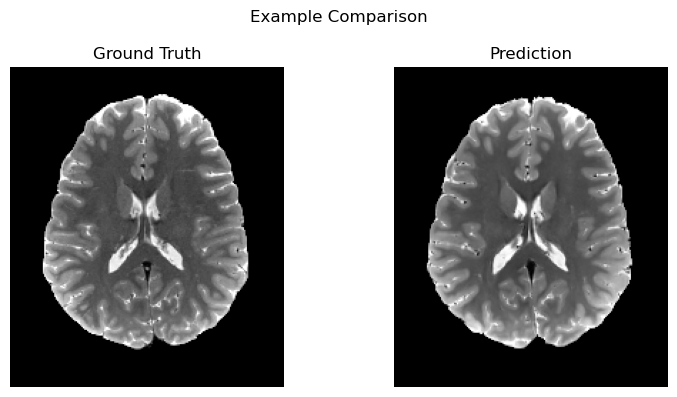

eval/mse_mean,▁
eval/mse_var,▁
eval/psnr_mean,▁
eval/psnr_var,▁
eval/ssim_masked_mean,▁
eval/ssim_masked_var,▁
eval/ssim_mean,▁
eval/ssim_var,▁
eval/mse_mean,0.01534
eval/mse_var,8e-05
eval/psnr_mean,20.11515


,Metric,Mean,Variance
0,SSIM,0.798429,0.002054
1,MASKED_SSIM,0.812902,0.001249
2,MSE,0.015338,0.000079
3,PSNR,20.115155,3.697408


In [18]:
with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/psnr_mean": summary["Mean"][3]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
    wandb.log({"eval/psnr_var": summary["Variance"][3]})
summary

## Retrain with the small Unet and scheduler

In [10]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6, num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6, num_workers=2, shuffle=False)

device = torch.device("cuda")
num_train_timesteps = 1000

model = DiffusionModelUNet(
    spatial_dims=2,  #  2D
    in_channels=2,  # x
    out_channels=1,  # predice delta_x_t
)

scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
inferer = DiffusionInferer(scheduler)

In [ ]:
exp_name = "diffusion-t1t2-brains300e"
best_model_path = train_diffusion(
    model=model,
    inferer=inferer,
    train_loader=train_loader,
    val_loader=val_loader,
    project="FlowMatching-Baselines",
    exp_name=exp_name,
    notes="Training a diffusion model for T1-T2 brain image generation.",
    n_epochs=300,
    lr=3e-4,
    generation_steps=num_train_timesteps
)
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()



with wandb.init(
    project = 'FlowMatching-Baselines',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the diffusion model on the test set.",
):
    generate_and_save_predictions(
        model=model,
        inferer=inferer,
        test_loader=test_loader,
        device=device,
        output_dir=f'{OUTPUT_DIR}/{exp_name}',
    )
    out_dataset = PredictionDataset(f'{OUTPUT_DIR}/{exp_name}')
    summary = compute_ssim_from_dataset(out_dataset)
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/psnr_mean": summary["Mean"][3]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
    wandb.log({"eval/psnr_var": summary["Variance"][3]})
summary

wandb: Currently logged in as: andreamoschetto99 (andreamoschetto99-university-of-catania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using Tesla T4


Epochs:  64%|█████████████████████████████████                   | 191/300 [12:48:31<7:28:49, 247.06s/it]